# Visium-Clustergrammer2

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
df = {}

from clustergrammer2 import net

import ipywidgets as widgets
import numpy as np
from bqplot import pyplot as plt
import bqplot
from ipywidgets import HBox

from copy import deepcopy
from glob import glob
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import Voronoi

import warnings
warnings.filterwarnings('ignore')

>> clustergrammer2 backend version 0.5.5


# Load Cell Metadata

In [3]:
df = pd.read_csv('data/processed/df_meta.csv', index_col=0)
df.shape

(2696, 12)

In [4]:
df.head()

,gex-umi-sum,num_expressed_genes,gex-ribo-avg,gex-mito-avg,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres,pos-x,pos-y,gex-umi-sum-norm
AAACAAGTATCTCCCA,13069,4242,7.380952,97.600000,1,50,102,7475,8501,8501,2994,0.194714
AAACACCAATAACTGC,37448,7860,19.809524,256.666667,1,59,19,8553,2788,2788,1916,0.557934
AAACAGAGCGACTCCT,28475,6332,15.123810,275.533333,1,14,94,3164,7950,7950,7305,0.424246
AAACAGCTTTCAGAAG,39718,7957,27.676190,184.400000,1,43,9,6637,2099,2099,3832,0.591755
AAACAGGGTCTATATT,33392,7791,23.447619,117.600000,1,47,13,7116,2375,2375,3353,0.497504


In [5]:
df['plot-x'] = df['pos-x'].apply(lambda x: x/2 - 700)
df['plot-y'] = df['pos-y'].apply(lambda x: x/2 )

# Load GEX Data

In [6]:
df_gex = pd.read_csv('data/processed/gex.csv', index_col=0)
df_gex.shape

(250, 2696)

In [7]:
x_dim = 2000
y_dim = 2000

fig = plt.figure()

scatter = plt.scatter(df['plot-x'], 
                      df['plot-y'],
                      display_names=False, 
                      default_size=20)


scatter.default_size = 100
scatter.default_opacities = [0.5]*5164

top_margin = 200
inst_width = 800
inst_height = 1000
fig.layout.min_height = str(inst_height) + 'px'
fig.layout.min_width  = str(inst_width) + 'px'

plt.xlim(0, 2.0*x_dim)
plt.ylim(0, 2.0*y_dim)
fig.title = 'Visium Tissue'
fig.fig_margin = {'top': top_margin, 'bottom': 5, 'left': 5, 'right': 5}


In [8]:
# df['gex-umi-sum'].tolist()

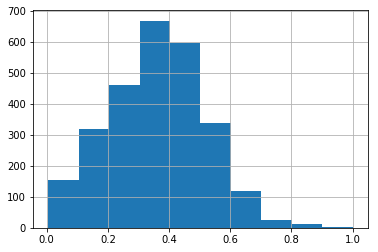

In [9]:
df['gex-umi-sum-norm'].hist()

In [10]:
def cat_highlight(inst_value):



    
    
#     if inst_value != 'reset_cats':
        
#         inst_cat = inst_value.split(': ')[1]

#         list_opacities = []

#         for inst_label in region_labels:
#             inst_opacity = 0.25
#             if inst_label == inst_cat:
#                 inst_opacity = 1
#             list_opacities.append(inst_opacity)

#     else:
#         list_opacities = [1 for x in region_labels]
#         # patch.opacities = list_opacities
#         scatter.default_opacities = list_opacities

    # patch.opacities = list_opacities
    scatter.default_opacities = df['gex-umi-sum-norm'].tolist() # list_opacities

In [11]:
def on_value_change(change):
    
    if change['new'] == 'null':
        cat_highlight('reset_cats')            
    else: 
        # mousing over category
        if 'cat-' in change['new']:
            inst_cat = change['new'].split(' -> ')[1]
            cat_highlight(inst_cat)       
            
        # mousing over marker
        else:
            inst_marker = change['new'].split(' -> ')[1]
            ser_opacity = df_gex.loc[inst_marker]
            
            
            # the scatterplot dots are not in the same order as the data in the dataframe
            #list_opacities = [float(x/ser_opacity.max()) for x in list(ser_opacity.get_values())]
            
            # loop up opacities
            list_opacities = []
            rows = ser_opacity.index.tolist()
            for inst_name in df_gex.columns.tolist():
                if inst_name in rows:
                    list_opacities.append( float(ser_opacity[inst_name]/ser_opacity.max())  )
                else:
                    list_opacities.append(0)
                
            scatter.default_opacities = list_opacities


In [12]:
net.viz = net.load_json_to_dict('data/processed/pre-calc-viz.json')
net.widget()
net.widget_instance.observe(on_value_change, names='value')

In [13]:
HBox([fig, net.widget_instance])